In [1]:
import pandas as pd
from datetime import datetime,timedelta
import plotly.express as px

In [2]:
physical_constants={
    'ml_to_oz':29.5,
    'lb_to_kg':0.453592,
    'kg_to_target_Cal_min':100,
    'kg_to_target_Cal_max':120,
    'expressed_caloric_density':18
}

In [3]:
formula_energy_density=pd.DataFrame.from_dict({
    'density':[20,24,22],
    'first_date':[datetime.strptime(date, '%m/%d/%y') for date in ['7/8/24','8/22/24','8/28/24']],
    'last_date':[datetime.strptime(date, '%m/%d/%y') for date in ['8/21/24','8/27/24','8/28/24']]
})

In [4]:
formula_path='/Users/pgleasonbremer/coding_projects/jace/jace-caloric-analysis/resources/Jace_formula.csv'
expressed_path='/Users/pgleasonbremer/coding_projects/jace/jace-caloric-analysis/resources/Jace_expressed.csv'
growth_path='/Users/pgleasonbremer/coding_projects/jace/jace-caloric-analysis/resources/Jace_growth.csv'

In [5]:
def convert_time_to_date(df):
    df['date']=df['Time'].str.split(', ').str[0]
    df=df.drop('Time',axis='columns')
    df['date']=pd.to_datetime(df['date'])
    return df

In [6]:
def clean_food_df(df,new_volume_name):
    df.drop(['Baby','Note'],axis='columns',inplace=True)
    df.rename({'Amount (ml)':new_volume_name},axis='columns',inplace=True)
    df=df.groupby('date').sum()
    df=df.reset_index()
    return df

In [7]:
def insert_formula_density(df,formula_density):
    formula_densities=[]
    for index,series in df.iterrows():
        target_date_formula_energy_density=formula_density.loc[
            (formula_density['first_date'] <= series['date']) &
            (formula_density['last_date'] >= series['date'])
        ].reset_index().at[0,'density']
        formula_densities.append(int(target_date_formula_energy_density))
        
    df['formula_density']=formula_densities
    return df

In [8]:
def clean_growth_df(growth_df):
    growth_df.drop(['Baby','Length (inches)','Head Size (inches)','Note'],axis='columns',inplace=True)
    growth_df.rename({'Weight (lbs.)':'weight_lbs'},axis='columns',inplace=True)
    return growth_df

In [9]:
def interpolate_weights(food_df,growth_df):
    '''
    uses the food df to determine upper and lower bounds for weights

    assume all days have a weight
    '''
    weight_lbs=[]
    start_date=food_df.at[0,'date']
    end_date=food_df.at[len(food_df.index)-1,'date']

    dates=[]
    weights=[]

    
    current_date=start_date
    while current_date<=end_date:

        # print(current_date)
        dates.append(current_date)

        # if current_date in growth_df['date'].values:
        #     exact_value = growth_df.loc[growth_df['date'] == current_date].reset_index().at[0,'Weight (lbs.)']
        #     # weights.append(exact_value)  # Since the same date would be used twice, the weighted average is just the value itself
        #     print(f'{current_date} {exact_value}')

        # else:
        #     # growth_df.locgrowth_df['date'] <= current_date]    .reset_index().at[growth_df.loc[growth_df['date'] <= current_date].reset_index().index[-1],'date']    #     # growth_df.locgrowth_df['date'] > current_date].reset_index().at[0,'date']
        #     previous_date=growth_df.loc[growth_df['date'] < current_date].reset_index().at[0,'date']
        #     # next_date=growth_df.loc[growth_df['date'] > current_date].reset_index().at[0,'date']
        #     print
        #     print(f'{current_date} {previous_date} {next_date}')

        weights.append(growth_df.loc[growth_df['date']<current_date].reset_index().at[0,'weight_lbs'])
        # hold=input('hold')[next_date = 

        current_date+=timedelta(days=1)

    return pd.DataFrame.from_dict({'weight_lbs':weights,'date':dates})
        

In [26]:
formula_df=pd.read_csv(formula_path)
expressed_df=pd.read_csv(expressed_path)
growth_df=pd.read_csv(growth_path)

formula_df=convert_time_to_date(formula_df)
formula_df=clean_food_df(formula_df,'mL_formula')

expressed_df=convert_time_to_date(expressed_df)
expressed_df=clean_food_df(expressed_df,'mL_expressed')

formula_df=insert_formula_density(formula_df,formula_energy_density)

growth_df=convert_time_to_date(growth_df)
growth_df=clean_growth_df(growth_df)

growth_df=interpolate_weights(formula_df,growth_df)


overall_df=expressed_df.merge(formula_df,how='inner',on='date')
overall_df=overall_df.merge(growth_df,how='inner',on='date')
overall_df['consumed_calories']=(overall_df['formula_density']*overall_df['mL_formula']/physical_constants['ml_to_oz'])+(physical_constants['expressed_caloric_density']*overall_df['mL_expressed']/physical_constants['ml_to_oz'])

overall_df['target_calories_max']=overall_df['weight_lbs']*physical_constants['lb_to_kg']*physical_constants['kg_to_target_Cal_max']
overall_df['target_calories_min']=overall_df['weight_lbs']*physical_constants['lb_to_kg']*physical_constants['kg_to_target_Cal_min']

overall_df['consumed_cal_as_percent_of_min']=100*overall_df['consumed_calories']/overall_df['target_calories_min']

/var/folders/3f/wvdgpt711h7dr3_my_kjhw2h0000gp/T/ipykernel_59579/3504315389.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/3f/wvdgpt711h7dr3_my_kjhw2h0000gp/T/ipykernel_59579/3504315389.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/3f/wvdgpt711h7dr3_my_kjhw2h0000gp/T/ipykernel_59579/3504315389.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [22]:
overall_df

,date,mL_expressed,mL_formula,formula_density,weight_lbs,consumed_calories,target_calories_max,target_calories_min
0,2024-07-08,290,90,20,7.38,237.966102,401.701075,334.750896
1,2024-07-09,504,42,20,7.19,336.000000,391.359178,326.132648
2,2024-07-10,593,60,20,7.31,402.508475,397.890902,331.575752
3,2024-07-11,470,220,20,7.31,435.932203,397.890902,331.575752
4,2024-07-12,525,125,20,7.31,405.084746,397.890902,331.575752
5,2024-07-13,640,121,20,7.31,472.542373,397.890902,331.575752
6,2024-07-14,526,155,20,7.31,426.033898,397.890902,331.575752
7,2024-07-15,570,155,20,7.31,452.881356,397.890902,331.575752
8,2024-07-16,525,120,20,7.94,401.694915,432.182458,360.152048
9,2024-07-17,545,220,20,7.94,481.694915,432.182458,360.152048


In [23]:
plotly_list_numbers=[]
plotly_list_type=[]
plotly_list_dates=[]
for index,series in overall_df.iterrows():
    plotly_list_numbers.append(series['consumed_calories'])
    plotly_list_numbers.append(series['target_calories_max'])
    plotly_list_numbers.append(series['target_calories_min'])
    plotly_list_type.append('consumed_calories')
    plotly_list_type.append('target_calories_max')
    plotly_list_type.append('target_calories_min')
    plotly_list_dates.append(series['date'])
    plotly_list_dates.append(series['date'])
    plotly_list_dates.append(series['date'])
plotly_df=pd.DataFrame.from_dict({'numbers':plotly_list_numbers,'type':plotly_list_type,'date':plotly_list_dates})

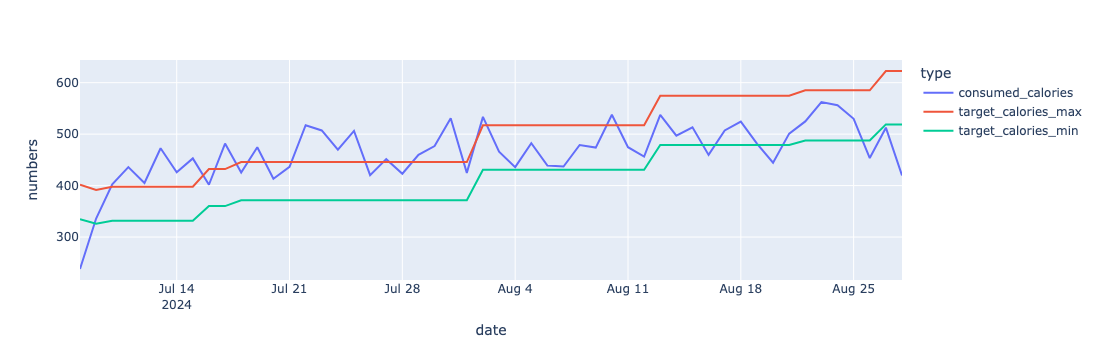

In [25]:
px.line(plotly_df,x='date',y='numbers',color='type')

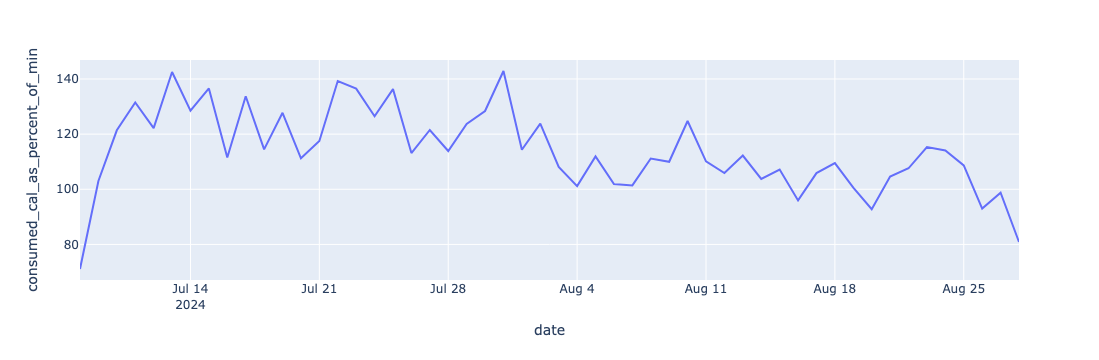

In [27]:
px.line(overall_df,x='date',y='consumed_cal_as_percent_of_min')